# Introduction to the Complex Analysis

This is the complex analysis expanding on what is covered in the article posted on Medium.com. If you would like to know more about it click the link: [CRISP-DM Regression Analysis in Python](https://medium.com/p/ade4b74bdc85/edit)

# Data Handling

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from helper import unzip_files
from helper import cleaning_dollar
from helper import cleaning_percent
from helper import AnalysisStatus
from helper import DummySplit
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
%matplotlib inline

plt.style.use('default')

# Preparing for Extract
---

In [2]:
# getting zip file name
data_zip = os.listdir('data')
data_zip

['calendar.csv', 'listings.csv', 'reviews.csv', 'seattle.zip']

In [3]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

calendar.csv already extracted!
listings.csv already extracted!
reviews.csv already extracted!


['calendar.csv', 'listings.csv', 'reviews.csv', 'seattle.zip']

# Extracting the Calendar Dataset
---

In [4]:
df_calendar = pd.read_csv('data\calendar.csv')

## Distribution of calendar features

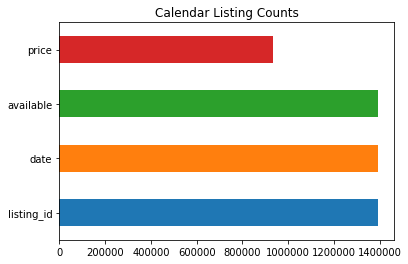

In [5]:
df_calendar.count().plot.barh(title="Calendar Listing Counts");

## Relationship Between Nulls Prices and Availability of Listing

In [6]:
df_calendar.assign(null_price=lambda x: (x.price.apply(type) == float)).groupby(
    ['available', 'null_price']).count()

,,listing_id,date,price
available,null_price,,,
f,True,459028,459028,0
t,False,934542,934542,934542


**Analysis:** Only price is missing values. However, we can notice that there is a relationship between the null values and the listing not being available. This suggests that all nulls are actually zero values.

# Extracting the Listings Dataset
---

In [7]:
df_listings = pd.read_csv('data\listings.csv')

## Distribution of listings features

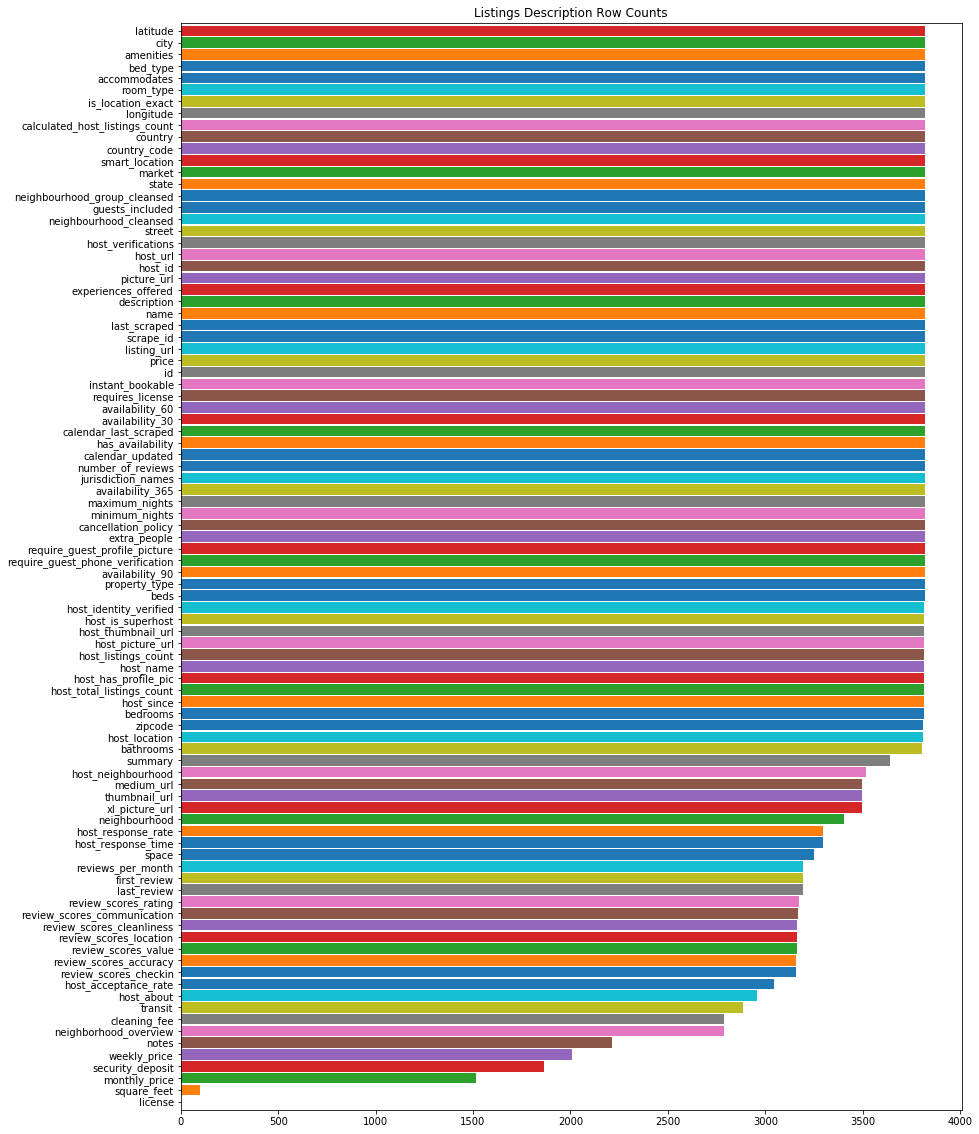

In [8]:
df_listings.count().sort_values().plot.barh(
    legend=False, 
    figsize=(14, 20), 
    rot=0, 
    width=.9,
    title="Listings Description Row Counts");

**Analysis**: We can quickly see features with extreme missing values that we should remove.

##  Distribution of listings Nulls

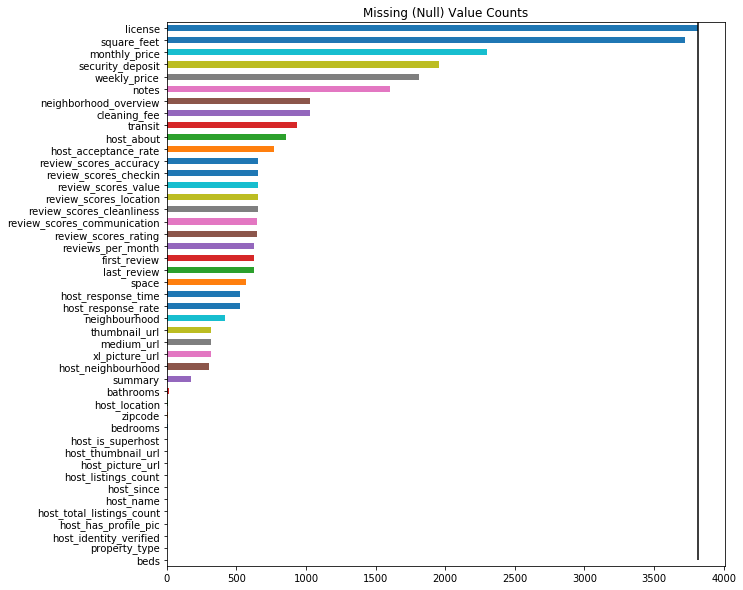

In [9]:
# Extracting only null counts
sr_listing_nulls = df_listings.isnull().sum().where(
    lambda x: x > 0).dropna(
    ).sort_values(ascending=True)

# Plotting the null counts
sr_listing_nulls.plot.barh(
    figsize=(10, 10), title="Missing (Null) Value Counts");
plt.vlines(df_listings.shape[0], 100, 0);

In [10]:
sr_extreme_null = (sr_listing_nulls/df_listings.shape[0]).where(
    lambda x: x>.90).dropna()
sr_extreme_null

square_feet    0.974594
license        1.000000
dtype: float64

**Analysis**: We can see that <mark><strong>license and squared_feet </strong></mark> have extreme nulled values. For this reason, we are removing them.

In [11]:
df_listings.drop(sr_extreme_null.index, axis=1, inplace=True)

# Extracting the Reviews Dataset
---

In [14]:
df_reviews = pd.read_csv('data/reviews.csv')

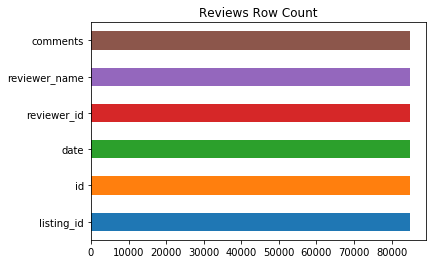

In [15]:
df_reviews.count().plot.barh(title="Reviews Row Count");

**Analysis**: Simple. Reviews are all complete.

# Understanding Calendar

##  First 5 Rows

In [16]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


##  Availability Counts

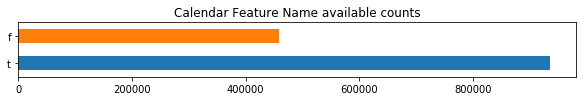

In [17]:
df_calendar.available.value_counts().plot.barh(
    figsize=(10, 1), 
    title='Calendar Feature Name available counts', 
    legend=False);

##  Price Formats

In [18]:
df_calendar.price.str.findall('\D').value_counts().to_frame('price_counts')

,price_counts
"[$, .]",933845
"[$, ,, .]",697


In [19]:
# type of date
df_calendar.date.apply(type).unique()

array([<class 'str'>], dtype=object)

**Analysis**: We will need to clean these invalid characters from the prices. And we need to convert string dates to datetime.

In [20]:
# Cleaning prices
df_calendar.price = cleaning_dollar(df_calendar.price)

# Converting date to datetime
df_calendar.date = pd.to_datetime(df_calendar.date)

In [21]:
# Validating price conversion
df_calendar.price.apply(type).unique()

array([<class 'float'>], dtype=object)

In [22]:
# type of date conversion
df_calendar.date.apply(type).unique()

array([<class 'pandas._libs.tslibs.timestamps.Timestamp'>], dtype=object)

## Price Line Trends by Dataset Source

### Aggregate Price Trend with Filtered Nulls

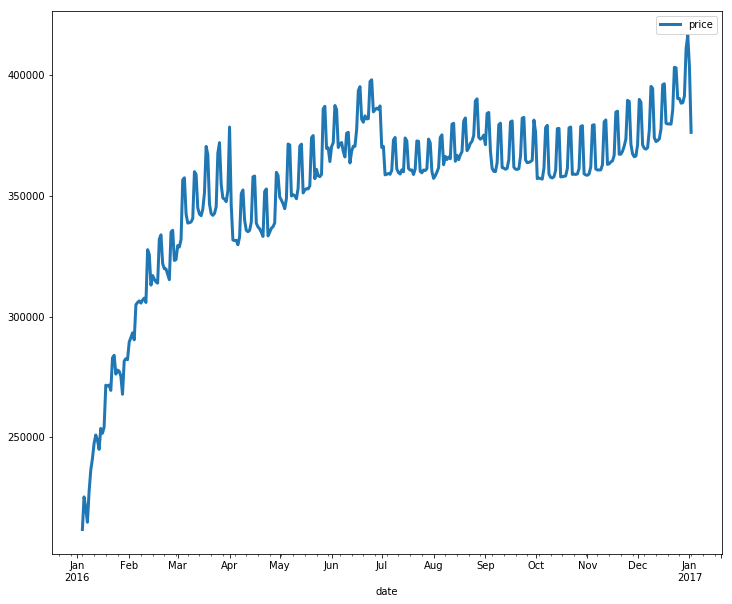

In [23]:
df_calendar.groupby(['date']).agg({'price':'sum'}).plot.line(
    figsize=(12, 10), lw=3);

In [26]:
df_calendar.date.describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

In [41]:
df_calendar.assign(
    month=lambda x: x.date.dt.to_period("M")
    ).month.value_counts()

2016-03    118358
2016-07    118358
2016-10    118358
2016-08    118358
2016-05    118358
2016-12    118358
2016-04    114540
2016-06    114540
2016-11    114540
2016-09    114540
2016-02    110722
2016-01    106904
2017-01      7636
Freq: M, Name: month, dtype: int64

**Analysis**: Seattle seem to have been serviced for the first time in January 2016. And the last month seem to be an incomplete month--with only 2 days of the month provided.

### Price Trend with Zeroed Nulls

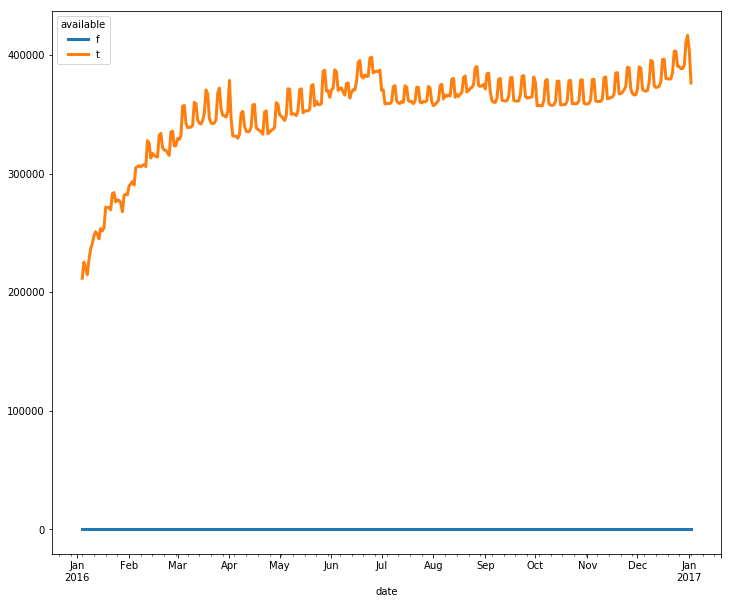

In [58]:
df_calendar.fillna(0).groupby(['date', 'available']).agg(
        {'price':'sum'}
    ).reset_index().pivot(
        index='date', 
        columns='available', 
        values='price').plot.line(
    figsize=(12, 10), lw=3);

**Analysis**: Null values ranges from start to end. We can safely assume this is normal and these values are actually $0 because they are not listed. <mark><strong>We are removing unavailable listings.

In [59]:
df_calendar = df_calendar.query("available=='t'")

# CHECKPOINT CHECKPOINT CHECKPOINT

# Understanding Listings
---

## Analyzing Object Features of Listings

In [ ]:
# Calculating missing percentages of total listings
missing_pct = listings.isnull().sum() / listings.shape[0]

# Listings examples with missing percentages
pd.options.display.max_rows = 100

listings.select_dtypes(include=object).dropna(
    axis=0, how='all').sample(1).T.merge(
        missing_pct.to_frame('missing'),
        left_index=True,
        right_index=True,
        how='left').iloc[:, [1, 0]].sort_values(
            'missing', ascending=False).style.bar()

## Analying Numeric Features of Listings

In [ ]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T.merge(
    missing_pct.to_frame('missing'),
    left_index=True,
    right_index=True,
    how='left').iloc[:, [-1, 0, 1, 2, 3]].sort_values(
        'missing',
        ascending=False).style.format("{:2,.2f}").bar(subset=['missing'])

## Analyzing Date Features of Listings --RC

In [ ]:
listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

In [ ]:
listings['last_scraped'].unique()

**Analysis**: We can see that we have to do some imputations on the reviews for the numerical fields. For the object fields, there are some numerical values that will have to be cleaned and some irrelevant columns such as URLs and names. One thing to notice is that **amenities** and **host_verification** can be split and converted to dummy variables. These could be helpful to the model.

Perhaps the **calendar_last_scraped** feature has a meaningful link to the dataset. The other dates (**first_review, host_since, and last_review**) could be used to engineer new features. Only **last_scraped** seems to be irrelevant in this case since it only describes the date the datasets where extracted.

In [ ]:
func_drop_normal('last_scraped')

# Uderstanding Reviews

##  Frist 5 Rows

In [ ]:
reviews.head()

## Id Relationships Lenght Box Plots

In [ ]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

In [ ]:
len_func = lambda x: x.str.len()

listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

In [ ]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

**Analysis**: We can surely see these are just individual reviews for the listings. Given that there are reviewer-ids with a length of 2 and 3 in the reviewers dataset and not in the listings dataset, we can assume that the listings don't include stays (missing records) for those host with 2 and 3 length-ids, but those hosts have reviews for the listings in the reviewer dataset.

* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so, therefore, it is irrelevant for the analysis. However, this id could be related to the calendar date since it could mean that the data was scraped during a specific calendar date.
* The host_id in the listing dataset seems to be related to the reviewer_id of the reviews dataset.

# Calendar Granularity

## Calendar Duplicates

In [ ]:
calendar_dup = calendar.groupby(
    ['date', 'listing_id', 'rowsource',
     'available']).size().to_frame('duplicates').query("duplicates>1")
calendar_dup.head()

In [ ]:
calendar_price_dups = calendar_dup.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {calendar_price_dups}")

### Examples of Calendar Duplicates --RR

In [ ]:
# Conditions
date_dup = calendar_dup.reset_index().date.astype(str).values.tolist()
date_filter = calendar.date.astype(
    str).apply(lambda x: True if x in date_dup else False)
filter_cond = (calendar.listing_id == 12898806) & date_filter

# Duplicate Examples
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

**Analysis**: There are 365 duplicates in the calendar dataset. These duplicates can be safely removed since they all share the same information. It does not really matter if we keep the first or last. We are removing these duplicates.

The granularity of the table is at the following level:
* Date
* Listing Id

In [ ]:
# Flag where there are no duplicates
keep_first = ~calendar.duplicated(subset=['date', 'listing_id'], keep='last')

# Remove duplicates by slicing
calendar_clean = calendar[keep_first]

# Calculate the difference beteween sizes
dup_count = calendar_dup.count().values[0]
dup_removed = calendar.shape[0] - calendar_clean.shape[0]

print(f"There where {dup_count} duplicates and {dup_removed} where removed.")

# Listings Granularity

## First 5 Rows

In [ ]:
listings.head()

## Listings Duplicates

In [ ]:
listings.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

**Analysis**: Plain and simple, there are no duplicates in this dataset. Great!

The granularity is at the id level. All other features are aggregates or normalized records.

# Reviews Granularity

## First 5 Rows

In [ ]:
reviews.head()

## Reviews Duplicates

In [ ]:
reviews.groupby(['listing_id', 'reviewer_id', 'date',
                 'id']).size().to_frame('duplicates').query("duplicates>1")

In [ ]:
reviews.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

## Multiple Comments by Reviewer Relating to Listings

In [ ]:
reviews_duplicated = reviews.groupby([
    'listing_id', 'reviewer_id', 'date'
]).size().to_frame("duplicates").query("duplicates>1").reset_index()
reviews_duplicated.style.bar(subset=['duplicates'])

### Examples of Multiple Reviews per Listing

In [ ]:
reviews.merge(reviews_duplicated.drop('duplicates', axis=1),
              on=['listing_id', 'reviewer_id', 'date'], 
              how='left',
              indicator=True)\
    .query("_merge=='both'").head(6)\
    .style.background_gradient(subset=['reviewer_id'])

**Analysis**: This dataset has no duplicates as well as listings. 

The granularity of the dataset is also at the id level. In this case the review id.

However, as it relates to listings, there are several reviews for the same listing during the same date. Some of them have automated comments that could be impacting the overall listing reviews.

* Granulated at the listing_id, reviewer_id, and date level.
* Some duplicates by automation. 
* Some manual duplicates by reviewer with different commets for same date and listing.

# Testing Relationships beteween Datasets

## Relationship between Geo Columns

In [ ]:
# Get geo columns
geo_columns = listings.select_dtypes(include=object).columns[-10:][:-6].tolist()

listings[geo_columns].head()

* space and street are too long for this analysis

In [ ]:
# Removing long features
geo_columns.remove('space')
geo_columns.remove('street')

In [ ]:
# Mergin clean calendar with listings
airbnb_geo_test = calendar_clean.merge(
    listings[['id'] + geo_columns],
    left_on='listing_id',
    right_on='id',
    how='left',
    suffixes=['', '_list'],
    indicator=True)

In [ ]:
airbnb_geo_test.rowsource.value_counts()

In [ ]:
calendar_clean.rowsource.value_counts()

In [ ]:
airbnb_geo_test._merge.value_counts()

In [ ]:
airbnb_geo_test.groupby(['state', 'rowsource']).size()

In [ ]:
del airbnb_geo_test

**Analysis**: We can see that the calendar dataset has full relationship with listing, which is excactly what we need. This means that all calendar listings_ids have relationships with listings ids.

The merge worked, perfectly matching state and rowsource.

## Looking for Meaningful Relationship Between Listing and Reivews

### Assessing Reviews and Ids from Sample

In [ ]:
# Assessing duplicate id in listings again
print("There are" , 
      listings.id.value_counts().where(lambda x: x>1).sum(),
      "dupliate ids in the listing dataset.")

In [ ]:
airbnb_review_test = listings.merge(
    reviews, 
    left_on='id', 
    right_on='listing_id', 
    how='left', 
    suffixes=['', '_review'],
    indicator=True)

In [ ]:
airbnb_review_test.groupby(['state', 'rowsource_review']).size()

In [ ]:
listings.groupby(['state', 'rowsource']).size()

*We can see that reviews will have to be aggregated before joining to listings. But we will take care of that if it is necessary.

### Descriptive Statistics About Comments

In [ ]:
comment_listing_counts = reviews.groupby('listing_id').size().to_frame(
    'comment_count').groupby('comment_count').size().reset_index().rename(
        columns={0: 'total_unique_listing_ids'})

comment_listing_counts[['comment_count']].describe().T

In [ ]:
comment_listing_counts.groupby(
    pd.cut(comment_listing_counts.comment_count,
           bins=list(np.arange(0, 550, 50)))).sum()[[
               'total_unique_listing_ids'
           ]].reset_index().set_index('total_unique_listing_ids').rename(
               columns={'comment_count': 'comment_count_buckets'})

*We can see that most listings have from 1 to 50 comments to apply natural language processing to predict ratings in the listing dataset if needed.

## Relationship betwee Datasets Results

**Analysis**: The datasets agree on the state and the source file name. The join between dataset is valid.

The relationship between listing dataset reviews and reviews dataset comments is by the listing_id there are at most 474 reviews on at least one listing. Two listings have around 451 to 474 comments. However, the majority of the listings have 1 to 50 comments. So for some listing_ids predicting ratings might be difficult due to sparsity. 

The join for the final dataset is as follows:
* listing_id on calendar
* id on listings
* inner join on calendar side

# Preparing Data for Analysis --T

In [ ]:
# column additions for scatter and monthly comparisons
calendar_clean = calendar_clean.assign(date_num=lambda x: x.date.rank(method='dense'))

In [ ]:
# Get the month name
lmfunc_concat_name = lambda x: f"{x.month:02d}" + '-' + x.month_name() 
lmfunc_month_name = lambda x: x.date.apply(lmfunc_concat_name)

calendar_clean =  calendar_clean.assign(month_name=lmfunc_month_name)

## Calendar Removals or Imputations

###  Assessing Calendar Removal Impact

In [ ]:
data_formats = {'row_count':'{:2,.0f}', 'pct_total':'{:2.2%}'}

calendar_missing = calendar_clean.groupby('provided_flag').size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum())

calendar_missing.style.format(data_formats)

### Removal Percentages by Data Source

In [ ]:
calendar_rowsource_miss = calendar_clean.groupby(
    ['rowsource', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

calendar_rowsource_miss.style.format(data_formats)

### Removals by Month

In [ ]:
calendar_month_miss = calendar_clean.query("provided_flag=='MissingValue'").groupby(
    ['month_name', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

sns.barplot(
    x='pct_total', y='month_name', data=calendar_month_miss.reset_index());

### Price Distributions by Month, RowSource, Dates

In [ ]:
# Dataset groupings
calendar_price_bymonth = calendar_clean.reset_index(drop=True).pivot(
    columns='month_name', values='price')

calendar_price_bysource = calendar_clean.reset_index(drop=True)\
    .pivot(columns='rowsource', values='price')

# Title min max dates
max_date = str(calendar_clean.date.max().date())
min_date = str(calendar_clean.date.min().date())

# Starting subplot
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

plt.subplots_adjust(hspace=.3)

calendar_price_bymonth.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}',
    ax=ax[0])

calendar_price_bysource.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}', ax=ax[1])

plt.title('Prices Vs Dates Without Imputation')
sns.scatterplot(x='date_num', 
                y='price', 
                hue='rowsource', 
                data=calendar_clean, ax=ax[2])

plt.show()

### Price Relation with Availabity --RR

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Prices by Availability")
sns.boxenplot(
    x='available', y='price', data=calendar_clean.fillna(0));

**Analysis**: Simply removing all null prices will remove 41.62% of the calendar data. Most of it will be from the Boston dataset. However, missing prices are related to unavailable listings or available = f (for False).

As much as we want to prevent such drastic removals, we cannot do imputations for these nulls. We want to predict prices of listings and it is obvious that prices for unavailable listings are 0. For this reason, we are removing any null prices or all unavailable listings.

In [ ]:
# Validator
available_count = calendar_clean.query("available=='t'").shape[0]
print(f"There are {available_count:2,.0f} available listings in the calendar dataset.")

# Removing all Nulls
calendar_removals = calendar_clean.dropna()

# Validating
kept_count = calendar_removals.shape[0]
print(f"There are {kept_count:2,.0f} listings in the calendar dataset after removals.")

### Removing Other Irrelevant Columns --RC

In [ ]:
# Save date and date number for reference
date_references = calendar_removals[['date', 'date_num']]

In [ ]:
drop_columns = ['available', 'rowsource', 'provided_flag', 
                'source_group_flag', 'month_name', 'date']

# Removing non-predictors
try: calendar_removals = calendar_removals.drop(drop_columns, axis=1)
except: pass

### Finishing the Calendar Data Preparation and Releasing Objects from Memory

In [ ]:
# Copy calendar removals to the completed calendar
try:
    calendar_complete = calendar_removals.copy()
except:
    pass

del calendar_clean, 
del calendar_removals, 
del calendar_dup, 
del calendar_grp,
del calendar_missing, 
del calendar_month_miss, 
del calendar_price_bymonth,
del calendar_price_bysource, 
del calendar_rowsource_miss
del calendar_price_dups

calendar_complete.head()

### Checking Correlations of Final Calendar

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings)
analysis.correlation_heatmap(['date_num'])

Good. Alone with price, the date number has at least a low correlation with price, which means that there is  $𝑟^2$  percentage of explenation by daily movements. The rest can be attributed to other features that we are going to explore next.

## Listing Removals or Imputations

### Listings Null Analysis

In [ ]:
analysis.null_row_listingdist(30, 'Original Row Null Distribution')               

We are not observing an alarming rate of rows with null values across it. However, some of these features might be irrelevant for the analysis, and we should remove them. There could be other variables that can be impute. We will assess this distribution again after removals and imputations.

### Identifying Irrelevant Columns

In [ ]:
# target colmuns for imputations and transformations
target_columns = listings.isnull().sum().where(lambda x: x>0).dropna().index.tolist()
target_columns = ' '.join(target_columns)
target_columns

wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(target_columns)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


All of these features in the wordcloud need to be analyized for null relations to other feature values. But some of theme are irrelevant for the analysis such as those that finish with url.

### Columns to Remove due to Irrelevance

In [ ]:
# Irrelevant columns
irrelevant_columns = listings.columns.str.contains('url|name|about|pic')
irrelevant_columns = listings.columns[irrelevant_columns].tolist()

# Show irrelevant features
listings[irrelevant_columns].head(1).T.style.set_caption("Irrelevant Features")

These, above, are irrelevant columns since they describe web addresses and names. So there is no value to them in a regression analysis. 

On the contrary **host_has_profile_pic** and **require_guest_profile_picture** might add value to the model.

### Null Row Values Exceeding 10%

In [ ]:
analysis.null_row_feature_status(percentages=True, threshold=.10)

### Assessing Transformations of Informational Features

#### Examples of Informational Columns with Missing Values --T

In [ ]:
interest = ['']
iform_arguments = 'access|over|rule|notes|space|summary|transit|interaction|host_about|desc'
inform_columns = listings.filter(regex=iform_arguments).columns.tolist()
listings[inform_columns].head()

In [ ]:
# Values with 1 should match this
listings[inform_columns].isnull().sum()

*We are validating informational transformations to these null value counts.

In [ ]:
# listings checkpoint
listings_transform = listings.copy()

In [ ]:
# Conducting Transformations and Imputations
provided_func = lambda x: x.isnull()
inform_transform = listings_transform[inform_columns].where(provided_func, 0).fillna(1)

# creating the new column for provided access information
listings_transform.loc[:, inform_columns] = inform_transform

In [ ]:
# Matching 1 to provided information
listings_transform[inform_columns].sum()

*Tranformation checks out.

#### Checking Correlations of Informational Features

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(inform_columns)

#### Checking Null Distributions After Transformations

In [ ]:
analysis.null_row_listingdist(
    bins=30, title='Null Distribution After Informational Tranformations')

#### Informational Feature Transformation Results

These informational columns are not substantially correlated with price. For this reason, they will be removed from the dataset, with the exception of **house_rules** or **interaction**. They have the biggest correlation with price. However, they are also heavily correlated with each other. For this reason, we are going to pick just **house_rules** because it has the highest correlation with price.

We are also removing description since it had no nulls and by itself it provides no value given that the columns have too much categories of text.

We now have less row nulls than before. It is looking much cleaner.

In [ ]:
def func_drop_transform(column_list):
    """
    Droping columns from listing without having to write the whole line.
    
    parameter
    ---------
    column_list : column list to removed.
    """
    listings_transform.drop(column_list, axis=1, inplace=True)

In [ ]:
remove_cols = [x for x in inform_columns if x != 'house_rules']
func_drop_transform(remove_cols)

In [ ]:
analysis.null_row_feature_status(percentages=True)

### Assessing Dolar Value Features --C

In [ ]:
# Preparing for tranformations
clean_func = lambda x: cleaning_dollar(x)
dollar_columns = listings_transform.columns.str.contains('fee|price|deposit|extra')
dollar_columns = listings_transform.columns[dollar_columns].tolist()

listings_transform.loc[:, dollar_columns] = listings_transform[
    dollar_columns].apply(clean_func)

#### Checking Correlations for Dollar Features

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(dollar_columns)

**Analysis**: We can see that monthly price is highly correlated with price. But these two variables are linking variables, which means that manipulating one will manipulate the other one dependently. Therefore, monthly_price is not independent. We must remove it. The same applies to weekly_price.

So there is no use for using monthly_price and weekly_price to predict price because that is a bit redundant--no wonder they are heavily correlated. However, cleaning_fee and security_deposit are the main drivers of the listing price. Thus, we are dropping listing price derived features and keeping the fees, which are additions to the price.

The null rows are mostly clean at this time. We are doing a bit more cleaning, and we will be done.

In [ ]:
drop_dollarder = ['monthly_price', 'weekly_price']
func_drop_transform(drop_dollarder)

#### Imputations of Zero Fees and Deposits

In [ ]:
fee_columns = ['cleaning_fee', 'security_deposit']
listings_transform.loc[:, fee_columns] = listings_transform[fee_columns].fillna(0)

#### Checking Null Distributions After Removal of Pricing Derived Features and Imputations

In [ ]:
analysis.null_row_listingdist(
    bins=30, title='Null Distribution After Pricing Derived Removals')

*It is looking very clean now. But we still have more work to do--more cleaning.

In [ ]:
analysis.null_row_feature_status(percentages=True)

### Assessing Missing Geographical Features

#### 5 Sample Rows of Geographical Columns

In [ ]:
# Geo with nulls
geo_null_cololumns = [
    'jurisdiction_names', 'neighbourhood_group_cleansed', 'neighbourhood',
    'host_neighbourhood', 'host_location', 'city'
]

# Geo complete
geo_comp_columns = ['state', 'street']

listings_transform[geo_null_cololumns + geo_comp_columns].sample(5)

#### Jurisdiction and State

In [ ]:
listings_transform.fillna('missing').groupby(['state', 'jurisdiction_names']).size()

In [ ]:
# Fixing state
listings_transform.loc[:, 'state'] = listings_transform.state.apply(lambda x: x.upper())

#### Neighbourhood Features

In [ ]:
match_func = lambda x: x.neighbourhood == x.host_neighbourhood
listings_transform[[
    "neighbourhood_group_cleansed", "neighbourhood", "host_neighbourhood",
    "host_location", "neighbourhood_cleansed"
]].astype(str).assign(match=match_func).query("match==False").sample(5)

#### Missing City

In [ ]:
# Checking sparsity
listings_transform.city.value_counts().plot.barh(figsize=(10, 10));

#### Grouping Sparse Classes for City

In [ ]:
# Fixing sparsity issue
eng_group_bos = {True:'Boston'}
eng_group_sea = {True:'Seattle'}
eng_group_city = lambda x: x.str.contains('Boston|Seattle')

# Grouping Seattle Areas
fill_sea = listings_transform.city.str.contains('seattle', case=False)\
    .map(eng_group_sea)

# Grouping Boston Areas
fill_bos = listings_transform.city.str.contains('boston', case=False)\
    .map(eng_group_bos)

# Grouping Other Areas
group_sparse = fill_bos.fillna(fill_sea).where(eng_group_city, 'Other')

# Applying sparcity fix to city
listings_transform.loc[:, 'city'] = group_sparse

In [ ]:
# Plotting sparsity
listings_transform.city.value_counts().plot.barh(
    figsize=(10, 1), title='Sparsity after Grouping Classes')

# Checking sparsity
(listings_transform.city.value_counts()/listings_transform.city.count())\
    .to_frame().style.format("{:2.2%}")

**Analysis**: We found that **jurisdiction_names** are related identically to state and are completely missing for Massachusetts. Thus we are removing it. Also **neighbourhood_group_cleansed** has too many missing values to map with zipcodes to extract the neighborhood. We could get a dataset to map this. But for now, we will just remove it. There are some free zip code databases online that we can use to extract these. However, although **neighbourhood** has some duplicates and the process to extract those using zipcodes is not set yet. We are keeping this feature as predictor and converting the nulls to dummies.

We are removing **jurisdiction_names, neighbourhood_group_cleansed, and neighbourhood** from the listings and adding them to a tryout dataframe so we can pass it to the model for curiosity's sake. 

As for **city**, even though the nulls where insignificant, the sparsity of city groups were more concentrated in Boston and Seattle. We can use this feature but we need to group these sparse classes into other. However, some of these cities pertains to Boston, so we will need to map those.

In [ ]:
drop_columns = ['jurisdiction_names', 'neighbourhood_group_cleansed', 'neighbourhood']
tryout = listings_transform[drop_columns]
func_drop_transform(drop_columns)

In [ ]:
analysis.null_row_feature_status(percentages=True)

#### Assessing Has Availability Feature

In [ ]:
# number of zero prices
listings_transform.query("has_availability!=has_availability").price.where(
    lambda x: x == 0).dropna()

As we know available listings have prices. All listings have prices in the listings dataset. Therefore, has_availability should all be True. In this case, this feature provides no value to the model, and we will remove it.

In [ ]:
func_drop_transform('has_availability')

### Assessing Reviews

#### Reviews where Number of Reviews where not Zero

In [ ]:
# Columns related to reviews
review_columns = listings_transform.columns[
    listings_transform.columns.str.contains('review')]
review_columns = ['id'] + review_columns.tolist()

listings_transform[review_columns].query(
    "number_of_reviews!=0").isnull().sum().to_frame('missing')

*Where numer of reviews are not zero there are minimal null values that can be drop from the model, or just converted to the median rating for now.

#### Reviews where Number of Reviews where Zero

In [ ]:
listings_transform[review_columns].query("number_of_reviews==0").isnull().sum(
).to_frame('missing')

*All of these values have a meaning of no rating provided. Therefore, we should not remove any of these. Perhaps, what we can do is create another feature stating that the zero provided is actually a non provided field istead of an actual zero rating. The new feature will be called non_provided_rating.

#### Reviews where Number of Reviews where not Zero Including Reviews Dataset Merge

In [ ]:
listings_transform[review_columns].query("number_of_reviews!=0").merge(
    reviews.groupby('listing_id', as_index=False).sum(),
    left_on='id',
    right_on='listing_id',
    how='left',
    suffixes=['', '_reviews']).isnull().sum().to_frame('missing')

*There are comment that we could use to extract ratings using NLP. However, the extra work might not provide us the accuracy that we deserve given that there is so few missing ratings.

#### Transforming Reviews

In [ ]:
non_provided = listings_transform.filter(regex='score|review').drop(
    'number_of_reviews', axis=1).isnull().sum(axis=1)

non_provided.describe()

*The null reviews are for a whole row of ratings per specific listings. We can see that all rows have either 10 null rows or 0 rows nulls for specific listings.

In [ ]:
# Revie columns of interest
review_col = listings_transform.filter(regex='score|review').drop(
    'number_of_reviews', axis=1).columns.tolist()

# Transforming reviews where whole row is null
listings_transform = listings_transform.assign(
    non_provided_rating=non_provided.map({0:0, 10:1}))

# Filling all nulls to zero since they mean not provided reviews
listings_transform.loc[:, review_col] = listings_transform[review_col].fillna(0)

In [ ]:
# Validating the review transformations where number of reviwes is zero
listings_transform[review_columns].query("number_of_reviews==0").isnull().sum(
).to_frame('missing')

In [ ]:
# Validating firts_review and provided
listings_transform[review_columns +
                   ['non_provided_rating']].query("first_review!=0")[[
                       'first_review', 'non_provided_rating'
                   ]].sample(3)

In [ ]:
# Validating first review and not provided
listings_transform[review_columns +
                   ['non_provided_rating']].query("first_review==0")[[
                       'first_review', 'non_provided_rating'
                   ]].sample(3)

*The transformation worked. Let's see the correlation of it.

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
score_col = listings_transform.filter(regex='score').columns.tolist()
analysis.correlation_heatmap(['non_provided_rating'] + score_col)

**Analysis**: We can see that scores bring no value to the model. Therefore, we will remove all of these fields even though we still have null values for reviews that have number of ratings other than zero. This is because there is no chance that imputations will increase the insignificant correlations this score features provide.

In [ ]:
func_drop_transform(score_col)

####  **Engineering review_lag and review_rate** --E

In [ ]:
try:
    checkpoint
except:
    checkpoint = listings_transform.copy()

In [ ]:
# creating the lag between first and last review
day_func = lambda x: x.days
diff_func = lambda x: (pd.to_datetime(x.last_review) - pd.to_datetime(
    x.first_review)).apply(day_func)
reate_func = lambda x: (x.review_lag / x.number_of_reviews)

# engineering review lag
listings_transform = listings_transform.assign(review_lag=diff_func)

# engineering review rate
listings_transform = listings_transform.assign(review_rate=reate_func)

# dropping fist_review and last_review
review_dates = ['first_review', 'last_review']
listings_transform.drop(review_dates, axis=1, inplace=True)

In [ ]:
# Zero for no review provided
listings_transform.loc[:, 'review_rate'] = listings_transform.review_rate.fillna(0)

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(
    ['review_lag', 'review_rate', 'number_of_reviews', 'reviews_per_month'] +
    ['non_provided_rating'])

**Analysis**: We are removing **first_review** and **last_review** and replacing it with **review_lag** to account for the dates between the first review and the last review. We are also engineering the rate of reviews by dividing the **review_lag** by the **number_of_reviews**, this is the **review_rate**. But we can see that the review_lag provided no value to the model. So we will remove. 

The same way the **review_rate** ended up providing less value to the model than its derived feature, **number_of_reviews**. Thus, we are removing **review_rate**.

Also, the newly created feature **non_provided_rating** adds no value to the model. So we will remove it too.

**Engineering Description**:
* For the lag, we subtracted the first review date from the last review date.
* For the review rate, we divided the review lag by the number of reviews, which give us the rate of reviews between the first review date and the last review date.

We can see that the only valuable features are the **number_of_reviews** and **reviews_per_month**.

The **review_lag** is insignificant. So we will remove it too.

In [ ]:
func_drop_transform([
    'review_lag', 'review_rate',
    'non_provided_rating'
])

### **Removing Other Irrelevant Features** --RC

In [ ]:
irrelevant_columns.remove('host_about')

In [ ]:
irrelevant_columns

In [ ]:
possible_columns = ['host_has_profile_pic', 'require_guest_profile_picture']

# Remove irrelevant columns
drop_columns = [
    i for i in irrelevant_columns
    if i not in possible_columns + ['jurisdiction_names']
]

func_drop_transform(drop_columns)

**Analysis**: We ended up removing all irrelevant features except for  the picture related columns, which could be benefetial to the model.

### Host Acceptance and  Response Rate and Time

In [ ]:
# Cleaning percentages
listings_transform.loc[:, 'host_acceptance_rate'] = cleaning_percent(
    listings_transform.host_acceptance_rate)

listings_transform.loc[:, 'host_response_rate'] = cleaning_percent(
    listings_transform.host_response_rate)

In [ ]:
# Adding prefix
lmfunc_colname = lambda x: 'resp_t_' + str(x)

response_time = pd.get_dummies(
    listings_transform.host_response_time,
    dummy_na=True).rename(columns=lmfunc_colname)

# Extracting prefixed columns
response_time_col = response_time.columns.tolist()

In [ ]:
# Add newly created dummies for response time and delete original
listings_transform = pd.concat([listings_transform, response_time],
                               axis=1).drop(
                                   'host_response_time', axis=1)

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(['host_acceptance_rate', 'host_response_rate'] +
                             response_time_col)

**Analysis**: As we can see, **host_response_time** adds little value to the model. Thus, we will remove it. Also, **host_response_rate** adds no value to the model.

In [ ]:
func_drop_transform(['host_response_rate'] + response_time_col)

In [ ]:
analysis.null_row_feature_status(percentages=True)

In [ ]:
listings_transform.host_acceptance_rate.describe()

In [ ]:
listings_transform.host_acceptance_rate.plot.box(vert=False, figsize=(5, 1));

In [ ]:
# Imputating median to acceptance reate
resp_rate = listings_transform.host_acceptance_rate.median()
listings_transform.loc[
    :, 'host_acceptance_rate'] = listings_transform.host_acceptance_rate.fillna(
                           resp_rate)

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(['host_acceptance_rate'])

**Analysis**: We can see that the acceptance rate did provide value to the model. This feature had null values that where imputed with the median. The explanation is that in general, 50% of all the acceptance rates fall between or in 100%. Thus, the middle of the distribution is 100%--Kudos to AIRBNB and their hosts.

### Assessing Nulls at the Row Level

In [ ]:
analysis.null_row_listingdist(30, 'Null at Row Level After All Removals')

### Splitting, Engineering, and Removing amenities and host_verifications --E RC

In [ ]:
# Instantiationg encoder
ds = DummySplit(listings_transform)

# Original example
listings_transform[['amenities']].head()

In [ ]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy('amenities')
ds.add_dummies(drop_original=True)
amenities_columns = ds.dummy_columns[:]
ds.dummy_frame.head()

In [ ]:
# Original example
listings_transform[['host_verifications']].head()

In [ ]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy(feature_name='host_verifications')
ds.add_dummies(drop_original=True)
host_verifications = ds.dummy_columns[:]
ds.dummy_frame.head()

In [ ]:
# release memory
del ds

#### Checking Correlation of New Features

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)

In [ ]:
analysis.correlation_heatmap(amenities_columns, show_values=False)

In [ ]:
scope = ['AirConditioning', 'FamilyKidFriendly', 'CableTV', 'TV', 'ElevatorinBuilding']
analysis.correlation_heatmap(scope, show_values=True)

In [ ]:
analysis.correlation_heatmap(host_verifications, show_values=True)

**Analysis**: In the amenities we found that some features stand out with moderate correlations--AirConditioning, FamilyKidFriendly, CableTV, TV, and ElevatorinBuilding were some of them. These features will add values to the model. However, they are a slightly correlated with each other, except for FamilyKidFriendly and ElevatorinBuilding.

On the contrary, host_verividations did not have any valuable features extracted, except for amex, which scored a $r$ of .10. Perhaps, we can add it to the model at the end.

We are adding to the model the highest correlated features that have the lowest multicollinearity with each other.

### Final Transformations and Removals

#### **Removing Irrelevant Columns** -- RC

In [ ]:
removals = [
    'calendar_updated', 'experiences_offered', 'is_location_exact',
    'rowsource', 'zipcode', 'street', 'host_location', 'smart_location',
    'host_neighbourhood', 'neighbourhood_cleansed', 'country', 'country_code',
    'scrape_id'
]

listings_transform.drop(removals, axis=1, inplace=True)

#### Transformations of t/f Values

In [ ]:
transform = [
    'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost',
    'instant_bookable', 'require_guest_phone_verification', 'requires_license',
    'require_guest_profile_picture'
]

listings_transform.loc[:, transform] = listings_transform[transform].apply(
    lambda x: x.map({
        'f': 1,
        't': 0
    }))

listings_transform[transform].head()

#### **Engieneering host_lifetime from  host_since and calendar_updated** -- E

In [ ]:
engieneering = ['host_since', 'calendar_last_scraped']

# Engineering feature by subracting
host_lifetime = listings_transform.calendar_last_scraped.apply(
    pd.to_datetime) - listings_transform.host_since.apply(pd.to_datetime)

# Extracting date number
host_lifetime = host_lifetime.apply(lambda x: x.days)

# Deleting original from dataset
listings_transform.drop(engieneering, axis=1, inplace=True)

# Adding engineered feature to dataset
listings_transform['host_lifetime'] = host_lifetime

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)

In [ ]:
analysis.correlation_heatmap(['host_lifetime'])

#### Listings Engineered Feature Results

 A correlation of .1 is a small correlation. However, it could be beneficial to the model by a small margin. We will test the model with the highest correlated features first and will add some like this one to it to attempt to improve its scores.

## One-Hot Encoder

In [ ]:
checkpoint = listings_transform.copy()

### Applying Encoder to Categorical

In [ ]:
# Saving Categorical for further analysis
df_categorical = listings_transform.select_dtypes(include=object)

# Example of categorical
df_categorical.sample(2).T

### Applying One-Hot Encoder

In [ ]:
# Initiating Encoder
encoder = OneHotEncoder()

# Get only columns with categories
listings_object = listings_transform.select_dtypes(
    include=object)

# Get list of removal columns
remove_original = listings_object.columns.tolist()

# Fitting and tranforming categories
# Fill nulls with missing to create missing dummy
X_encoded = encoder.fit_transform(listings_object.astype(str))

# Remove original encoded columns
listings_transform.drop(remove_original, axis=1, inplace=True)

# Encoded coluns
columns_encoded = encoder.categories_

# Extracting from list of list
dummy_columns = []
for original, enc_col in list(zip(remove_original, columns_encoded)):
    for dummy in enc_col:
        dummy_columns.append(re.sub('\W', '', (original + '_' + dummy)))

# Creating dataframe
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=dummy_columns)

# Applying listings 
listings_encoded = pd.concat([listings_transform, X_encoded], axis=1)

## Correlation Analysis

In [ ]:
def refresh_analysis_encoded():
    """
    Re-runs the analysis class and updates its dataframe objects.
    It prepares for correlation status.
    """
    analysis.listings = listings_encoded
    analysis._merge()

In [ ]:
def drop_get_dummies(drop_list):
    """
    Drop dummies from transformed listings, refreshes the analysis, and
    updates the dummy_columns variable to use in correlation map.
    
    parameter
    ---------
    drop_list : the list of dummy features to drop from the analysis
    """
    global dummy_columns
    analysis.df_merged.drop(drop_list, axis=1, inplace=True)
    # refresh_analysis_encoded()
    dummy_columns = [x for x in dummy_columns if x not in drop_list]

def get_dummy_from_feature(feature_name):
    """
    Extracts the dummies relative to the feature from which it was created.
    
    parameter
    ---------
    feature_name : the feature to extract dummies from the trasformed listings
    """
    return [x for x in dummy_columns if feature_name in x]

In [ ]:
refresh_analysis_encoded()

### Finding Perfect Multicollinearity

In [ ]:
analysis.colliniearity_table(include_perfect=True)

#### Removing Ids

In [ ]:
drop_get_dummies(['id', 'listing_id'])

#### Market Vs. State Correlations with Price

In [ ]:
# Get target dummies
market_dummies = df_categorical.market.astype(
    str).apply(lambda x: 'market_' + re.sub('\W', '', x)).unique().tolist()

# Show correlation of target dummies only
# Adding State
analysis.correlation_heatmap(market_dummies + ['state_MA', 'state_WA'], show_values=True)

In [ ]:
df_categorical.market.value_counts()

**Analysis**: We can see there are some correlated fields. However, San Fransisco market stands out as having no correlation. Hence, there is low sparsity in San Fransisco.

Since markets other than Boston and Seattle are not well correlated with price, we are going to just drop market. Boston and Seattle markets are fully correlated with its state as it should. Thus, we are using state as a predictor instead of market.

Another interesting finding is state perfect multicollinearity. This means that I just can drop one of them and rename the other one state: 1 for Boston and 0 for Seattle

In [ ]:
drop_get_dummies(market_dummies)

#### Making State One Dummy

In [ ]:
# Validate with this
analysis.df_merged[[
    'state_MA', 'state_WA'
]].melt().where(lambda x: x.value == 1).dropna().variable.value_counts()

In [ ]:
# Droping Washington from state
drop_get_dummies(['state_WA'])

# Changing name
analysis.df_merged.rename(columns={'state_MA':'stateMApWAn'}, inplace=True)

In [ ]:
analysis.df_merged.stateMApWAn.value_counts()

#### Fixing Host Listing Count Multicollinearity

In [ ]:
analysis.correlation_heatmap(['host_listings_count', 'host_total_listings_count'])

**Analysis**: It does not matter wich one we remove, they are both correlated the same way with calendar listing price.

In [ ]:
drop_get_dummies(['host_total_listings_count'])

### Finding High Multicollinearity

In [ ]:
analysis.colliniearity_table(multi_r=.8)

#### Bed Vs. Accommodates

In [ ]:
analysis.correlation_heatmap(['beds', 'accommodates'])

**Analysis**: We see a high indication of multicollinearity with beds and accommodates. It make sense to think that a listing with more beds accommodates more people. However, accommodates have more corellation with calendar listing price than beds. For this reason, we are removing beds from the model.

In [ ]:
drop_get_dummies('beds')

#### Availability Features

In [ ]:
available_cond = analysis.df_merged.columns.str.contains('avail')
available_col = analysis.df_merged.columns[available_cond].tolist()
analysis.correlation_heatmap(available_col)

**Analysis**: All availability features are correlated with each other, except for availability_365. Nevertheless, it has an insignificant correlation with price. Thus, we are removing it. The other 3 (availability_30, availability_60, and availability_90) may be all calculated features and therefore have multicollinearity because of it. Base on the correlation with calendar listing price, we are not keeping any of them.

In [ ]:
drop_get_dummies(available_col)

#### Host Listings Vs. Calculated Host Listings

In [ ]:
analysis.correlation_heatmap(['host_listings_count', 'calculated_host_listings_count'])

**Analysis**: Giving that host_listings is heavily correlated with its calculated counterpart, we are keeping only the feature most correlated with calendar listing price, which is **host_listings**.

In [ ]:
drop_get_dummies('calculated_host_listings_count')

#### Removing Price in Listing Dataset

No need to analyize this. It is obvious that last sccraped price in listing will be slighly correlated with calendar listing price.

In [ ]:
drop_get_dummies('price_listing')

#### Internet and WirelessInternet Combination

In [ ]:
analysis.correlation_heatmap(['Internet', 'WirelessInternet'])

**Analysis**: They have almost the same correlation. However, removing one of them might create some bias since they mean exactly the same thing. Instead of removing it, we are just combining them into one.

The methodology is summing both dummies. If the value is zero, then no internet was provided. If not zero, then internet was provided. 

In [ ]:
print("This is the original shape of the model data", analysis.df_merged.shape)

In [ ]:
# Condensing dummie into one series
internet_condense = analysis.df_merged[['Internet', 'WirelessInternet'
                    ]].sum(axis=1).where(lambda x: x==0, 1)

internet_condense.value_counts()

In [ ]:
# Where sum of both is greater than zero, or at least one has internet
analysis.df_merged[['Internet', 'WirelessInternet'
                    ]].eval("Internet+WirelessInternet>0").value_counts()

In [ ]:
# Where there is a one on either of them, validation
analysis.df_merged.query("Internet==1 or WirelessInternet==1").shape

In [ ]:
drop_get_dummies('WirelessInternet')

In [ ]:
analysis.df_merged.loc[:, 'Internet'] = internet_condense

In [ ]:
analysis.correlation_heatmap(['Internet'])

#### Iron and HairDryer Combination

In [ ]:
analysis.correlation_heatmap(['Iron', 'HairDryer'])

**Analysis**: Since these two dummy variables most likely are offered one without the other, they have a high multicollinearity. However, we could engineer a new feature called iron_hairdryer to see if it performs better than the individual ones.

The methodology of the new feature (iron_hairdryer) is if the sum of both is 2, then they provided both iron and hair dryer--we set it to 1. If the sum is not 2, then they did not provided the combo and therefore is set to 0.

In [ ]:
# Combining into one series
combination_ind = analysis.df_merged[[
    'Iron', 'HairDryer'
]].sum(axis=1).where(lambda x: x == 0, 1)

combination_ind.value_counts()

In [ ]:
# Where sum of both is greater than zero, or at least one has internet
analysis.df_merged[['Iron', 'HairDryer'
                    ]].eval("Iron+HairDryer>0").value_counts()

In [ ]:
# Where there is a one on either of them, validation
analysis.df_merged.query("Iron==1 or HairDryer==1").shape

In [ ]:
analysis.df_merged.loc[:, 'iron_hairdryer'] = combination_ind

In [ ]:
analysis.correlation_heatmap(['Iron', 'HairDryer', 'iron_hairdryer'])

**Analysis**: Unexpected, but the combination of both did not added value to the model. We will only keep Iron for the analysis. 

In [ ]:
drop_get_dummies(['iron_hairdryer', 'HairDryer'])

### City Vs. State

In [ ]:
analysis.correlation_heatmap(['city_Seattle', 'city_Boston', 'city_Other', 'stateMApWAn'])

**Analysis**: We have the same causal multicollinearity than state vs. market since one is the parent of the other. Since we have converted state already, we are keeping state, even though Boston city has more correlation.

In [ ]:
drop_get_dummies(['city_Seattle', 'city_Boston', 'city_Other'])

### Private Room, Apartment, Entire Home, and House

In [ ]:
analysis.colliniearity_table(multi_r=.8)

In [ ]:
drop_get_dummies(['longitude', 'latitude'])

In [ ]:
drop_get_dummies(['host_id'])

**Analysis**: 
Longitude and latitude will not provide us valuable information since it has too many classes. 

Also, given that the property type and room type multicollinearity don't seem to be causal in nature. We are keeping these features as they are in the model.

#### Property Type Vs. Room Type

In [ ]:
room_type = get_dummy_from_feature('room_type')
property_type = get_dummy_from_feature('property_type')

In [ ]:
analysis.correlation_heatmap(room_type, show_values=True)

In [ ]:
df_categorical.property_type.value_counts()

**Analysis**: We can see a very high sparsity in the property type feature classess. We will have to group some categories to make it more even.

In [ ]:
# keeping columns
property_keep_col = ['property_type_Apartment', 'property_type_House']

# other columns
property_other_col = analysis.df_merged.filter(regex='property_type').drop(
    property_keep_col, axis=1).columns.tolist()

# Compact property type
property_other = analysis.df_merged[property_other_col].sum(axis=1)

drop_get_dummies(property_other_col)

analysis.df_merged.loc[:, 'property_type_other'] = property_other

In [ ]:
analysis.correlation_heatmap(property_keep_col + ['property_type_other'], show_values=True)

**Analysis**: House and apartment have multicollinearity and the high correlation goes to house. So basically by choosing to list an apartment or a house, we will not see a significant difference in price. Thus, each one of them will do well in the model We will remove apartment.

Private room and entire home are correlated as well. But entire apartment is the biggest. So we are removing private room following the same logic as before.

The rest looks ok. But the grouped property type other provides no value to the model. We can remove this one. So for property type we can say if it is a house, it will have a higher price than any other. If it is an apartment, it will follow the same logic since it is similarly correlated with price and with apartment.

In [ ]:
drop_columns = ['property_type_Apartment', 'room_type_Privateroom', 'property_type_other']
drop_get_dummies(drop_columns)

### Remove Final Nulls

In [ ]:
(analysis.df_merged.isnull().sum()/analysis.df_merged.shape[0]).where(lambda x: x>0).dropna()

**Analysis**: Given that the null values in the final frame is miniscule, we are safe to remove all of these values.

In [ ]:
analysis.df_merged.dropna(inplace=True)

### Reduce Dimensionality by Removing Low Correlated Features

In [ ]:
df_airbnb = analysis.df_merged
del analysis

In [ ]:
# Dropping the count of nulls
df_airbnb.drop('row_null_pct', axis=1, inplace=True)

In [ ]:
# Absolute collinearities with price
collinearity_price = df_airbnb.corr()[['price']].drop('price', axis=0).apply(abs)

In [ ]:
# Keeping only 5% and above
reduced_features = collinearity_price.sort_values(
    'price', ascending=False).where(lambda x: x > .0).dropna().index

reduced_features

### Variance Inflation Factor (VIF)

In [ ]:
def vif(dataframe):
    """
    Creates a series of variance inflation factors to determine their multicollinearity.
    parameter
    ---------
    dataframe : the final reduced dataset with substantial explanatory features correlated with
    dependent feature.
    """
    import warnings
    
    # ignore divide by zero warning
    warnings.filterwarnings("ignore")
    
    X = add_constant(dataframe)
    columns = X.columns
    
    # Factor container
    vif_factors = []
        
    shape_idx = X.shape[1]
    
    # For all features
    for i in range(shape_idx):
        print(f"[{'='*i}]{i/(shape_idx-1):2.2%}", flush=True, end='\r')
        
        vif_factor = variance_inflation_factor(X.values, i)
            
        # Factor for the feature
        vif_factors.append(vif_factor)
              
    warnings.filterwarnings("default")
        
    return pd.Series(vif_factors, index=columns)

In [ ]:
vif_factors = vif(df_airbnb[reduced_features])

In [ ]:
vif_factors

**Analysis**: We don't see any issues with mutlicollinearity, except for some dummy features. This is not necessarliy a problem. We are continuing the process with these features. 

### Time Series Cross Validation 

In [ ]:
df_airbnb.price.plot.box(vert=False)

In [ ]:
# # Ordering dataset chronologically
df_airbnb = df_airbnb.query("price < 1500").sort_values('date_num')

In [ ]:
df_airbnb.price.plot.box(vert=False)

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x='date_num', y='price', hue='stateMApWAn', data=df_airbnb);

In [ ]:
# dependable variable
y = df_airbnb.loc[:, 'price']

# explanatory features
X = df_airbnb[reduced_features]

In [ ]:
# split at 20% 
test_size = int(round(X.shape[0]*.20, 0))
train_size = X.shape[0] - test_size

print('Test Size: ', test_size, '\nTrain Size:', train_size)

# Train Set
X_train = X[:train_size]
y_train = y[:train_size]

# Test Set
X_test = X[train_size:]
y_test = y[train_size:]

# Modeling & Visualizations

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

In [ ]:
lgr.predict(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
predictions = lr.predict(X_test)

# Evaluating Results

In [ ]:
lgr.score(X_test, y_test)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
pd.Series(lr.coef_, index=X.columns).to_frame('coefficients').style.bar(align='mid').format('{:2.2f}')

# Conclussion